# Data Assimilation using ESMDA in Reservoir Simulation

*Advanced Data Assimilation using Ensemble Smoother Multiple Data Assimilation (ESMDA) in Reservoir Simulation.*

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import reservoir_simulator as rs

%load_ext autoreload
%autoreload 2   
#%load_ext line_profiler
#%load_ext memory_profiler

## Model parameters

In [2]:
# Grid extension
nx = 25 #20 # 60
ny = 25 #10 # 30
nc = nx*ny

# Permeabilities
perm_mean = 3.0
perm_min = 0.5
perm_max = 5.0 

# ESMDA parameters
ne = 100                  # Number of ensembles
dt = np.zeros(10)+0.0001  # Time steps (could be irregular, e.g., increasing!)
time = np.r_[0, np.cumsum(dt)]
nt = time.size

# Assumed sandard deviation of our data
dstd = np.zeros(nt) + 0.5

# Observation location indices (should be well locations)
ox, oy = 1, 1

# Wells (if None, first and last cells are used with pressure 180 and 120, respectively)
# wells = np.array([[15, 10, 180], [55, 25, 120], [30, 7, 140]])
wells = None

## Create permeability maps for for ESMDA

We will create a set of permeability maps that will serve as our initial guess (prior). These maps are generated using a Gaussian random field and are constrained by certain statistical properties.

In [3]:
# Get the model and ne prior models
RP = rs.RandomPermeability(nx, ny, perm_mean, perm_min, perm_max)
perm_true = RP(1)
perm_prior = RP(ne)

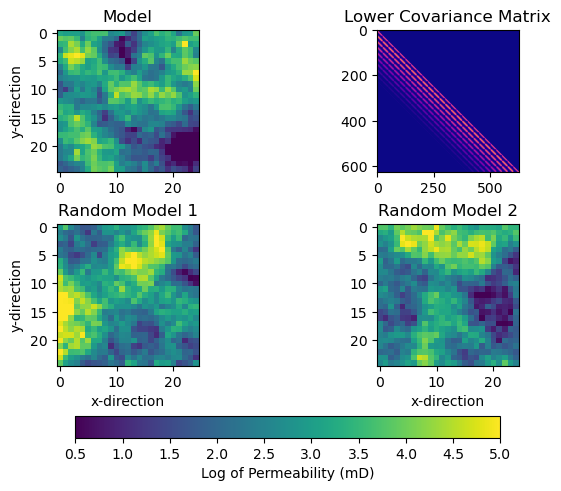

In [4]:
# QC covariance, reference model, and first two random models
fig, axs = plt.subplots(2, 2, constrained_layout=True)
axs[0, 0].set_title('Model')
im = axs[0, 0].imshow(perm_true.T, vmin=perm_min, vmax=perm_max)
axs[0, 1].set_title('Lower Covariance Matrix')
im2 = axs[0, 1].imshow(RP.cov, cmap='plasma')
axs[1, 0].set_title('Random Model 1')
axs[1, 0].imshow(perm_prior[0, ...].T, vmin=perm_min, vmax=perm_max)
axs[1, 1].set_title('Random Model 2')
axs[1, 1].imshow(perm_prior[1, ...].T, vmin=perm_min, vmax=perm_max)
fig.colorbar(im, ax=axs[1, :], orientation='horizontal', label='Log of Permeability (mD)')
for ax in axs[1, :]:
    ax.set_xlabel('x-direction')
for ax in axs[:, 0]:
    ax.set_ylabel('y-direction')

## Run the prior models and the reference case

In [5]:
# Instantiate reservoir simulator
RS = rs.Simulator(nx, ny, wells=wells)

def sim(x):
    """Custom fct to use exp(x), and specific dt & location."""
    return RS(np.exp(x), dt=dt, data=(ox, oy))
    
# Simulate data for the prior and true fields
data_prior = sim(perm_prior)
data_true = sim(perm_true)
data_obs = rs.rng.normal(data_true, dstd)

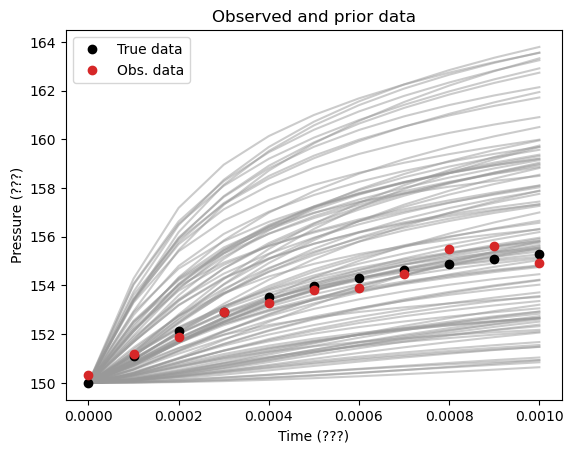

In [6]:
# QC data and priors
fig, ax = plt.subplots(1, 1)
ax.set_title('Observed and prior data')
ax.plot(time, data_prior.T, color='.6', alpha=0.5)
ax.plot(time, data_true, 'ko', label='True data')
ax.plot(time, data_obs, 'C3o', label='Obs. data')
ax.legend()
ax.set_xlabel('Time (???)')
ax.set_ylabel('Pressure (???)');

### ESMDA

In [7]:
perm_post, data_post = rs.esmda(model_prior=perm_prior, forward=sim, data_obs=data_obs, dstd=dstd, alphas=4,
                                data_prior=data_prior, vmin=perm_min, vmax=perm_max)

### Posterior Analysis
After running ESMDA, it's crucial to analyze the posterior ensemble of models. Here, we visualize the first three realizations from both the prior and posterior ensembles to see how the models have been updated.

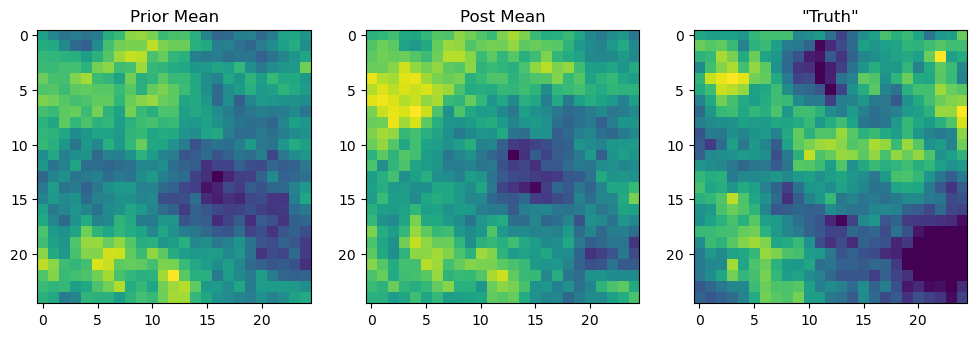

In [8]:
# Plot posterior
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].set_title('Prior Mean')
ax[0].imshow(perm_prior.mean(axis=0).T)
ax[1].set_title('Post Mean');
ax[1].imshow(perm_post.mean(axis=0).T);
ax[2].set_title('"Truth"');
ax[2].imshow(perm_true.T);

Observing the monitored pressure at cell (1,1) for all realizations and the reference case, we can see that the ensemble of models after the assimilation steps (in blue) is closer to the reference case (in red) than the prior ensemble (in gray). This indicates that the ESMDA method is effectively updating the models to better represent the observed data.

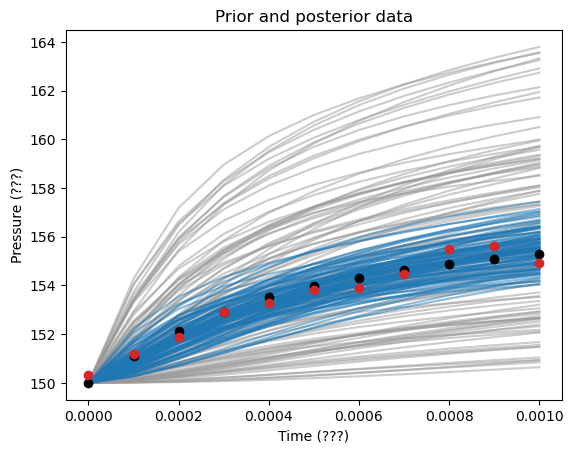

In [9]:
# Compare posterior to prior and observed data
fig, ax = plt.subplots(1, 1)
ax.set_title('Prior and posterior data')
ax.plot(time, data_prior.T, color='.6', alpha=0.5)
ax.plot(time, data_post.T, color='C0', alpha=0.5)
ax.plot(time, data_true, label='reference case' , marker='o', linestyle='', color = 'k')
ax.plot(time, data_obs, label='reference case' , marker='o', linestyle='', color = 'C3')
ax.set_xlabel('Time (???)')
ax.set_ylabel('Pressure (???)');

In [10]:
import scooby
scooby.Report()

--------------------------------------------------------------------------------
  Date: Mon May 06 18:14:06 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06)
  [GCC 11.3.0]

             numpy : 1.24.4
             scipy : 1.11.1
           IPython : 8.12.0
        matplotlib : 3.7.2
            scooby : 0.10.0

  Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------